# Lab 6: Exploring BiLSTMs for Telecom Customer Feedback Classification

## Objective

This laboratory session focuses on implementing Bidirectional Long Short-Term Memory (BiLSTM) networks for multi-task classification of telecom customer feedback. Students will build a model that can simultaneously predict both the category of customer complaints (**Network Issues**, **Billing**, **Customer Service**) and their sentiment (**Positive**, **Negative**). Through this practical implementation, students will:

- Understand how BiLSTMs process sequences bidirectionally to capture context from both past and future tokens.
- Compare their performance with traditional LSTMs.
- Implement a complete NLP solution using PyTorch.

## Dataset Description

We will be using a **Telecom Customer Reviews** dataset containing customer feedback with corresponding categories and sentiment labels.

### Data Dictionary

- **complaint_id**: Unique identifier for each complaint (e.g., `C0001`)
- **text**: Customer complaint/feedback text
- **category**: Category labels including:
  - Network Issues
  - Billing
  - Customer Service
- **sentiment**: Sentiment of the complaint
  - Positive
  - Negative

- **Total records**: 100
- **Features**: 4 columns

## Tasks to be Performed

### Tasks 1: Data Preprocessing and Exploration

1. **Load and explore the dataset**
2. **Analyze text lengths and distribution of categories/sentiments**
3. **Implement text cleaning:**
   - Remove special characters
   - Convert to lowercase
   - Remove stopwords
4. **Create vocabulary and convert text to sequences**
5. **Implement data splitting and create PyTorch DataLoaders**

### Tasks 2: BiLSTM Model Implementation

1. **Design a multi-task BiLSTM architecture:**
   - Shared BiLSTM layers
   - Separate classification heads for category and sentiment
2. **Create embedding layer with proper dimensionality**
3. **Implement forward pass with:**
   - Bidirectional processing
   - Hidden state concatenation
   - Multiple output heads

### Tasks 3: Model Training and Comparison

1. **Implement training loop with:**
   - Combined loss function for both tasks
   - Gradient clipping
   - Early stopping
2. **Train  models**
3. **Compare performance metrics:**

### Tasks 4: Analysis and Visualization

1. **Visualize Model Metrices**
2. **Create confusion matrices for both tasks**
3. ** Create sample code for usage**




#  1: Data Preprocessing and Exploration

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Load and explore the dataset
df = pd.read_excel('Reviews.xlsx')

# Display basic statistics
print("Dataset Shape:", df.shape)
print("\nCategory Distribution:")
print(df['category'].value_counts())
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

Dataset Shape: (100, 4)

Category Distribution:
category
Customer Service    35
Network Issues      34
Billing             31
Name: count, dtype: int64

Sentiment Distribution:
sentiment
Positive    52
Negative    48
Name: count, dtype: int64


In [33]:
df

,complaint_id,text,category,sentiment
0,C0001,My internet connection keeps dropping every fe...,Network Issues,Negative
1,C0002,I was billed twice this month. Please rectify ...,Billing,Negative
2,C0003,The customer service representative was very h...,Customer Service,Positive
3,C0004,I'm not satisfied with the call quality on my ...,Network Issues,Negative
4,C0005,The new data plan offers great value for money...,Billing,Positive
...,...,...,...,...
95,C0096,Had to escalate my issue due to unresponsive s...,Customer Service,Negative
96,C0097,Very satisfied with the reliable internet conn...,Network Issues,Positive
97,C0098,Billing errors were corrected without any hassle.,Billing,Positive
98,C0099,Customer service lacked the knowledge to resol...,Customer Service,Negative


In [34]:
# Calculate text length statistics
df['text_length'] = df['text'].str.len()
print("\nText Length Statistics:")
print(df['text_length'].describe())


Text Length Statistics:
count    100.000000
mean      60.780000
std        9.796495
min       40.000000
25%       53.000000
50%       60.000000
75%       66.000000
max       89.000000
Name: text_length, dtype: float64


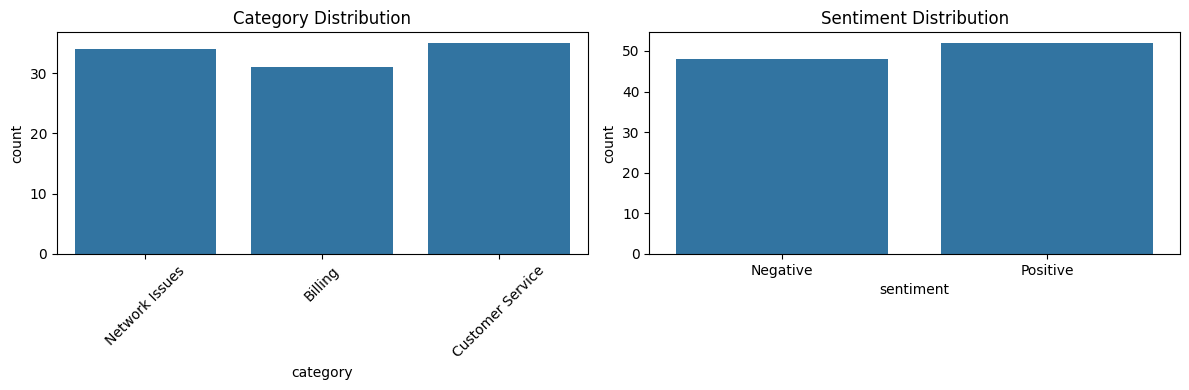

In [35]:
# Visualize distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='category')
plt.title('Category Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.tight_layout()
plt.show()

## Key Observations

### Balanced Class Distribution

- **Categories:**
  - Customer Service: 35
  - Network Issues: 34
  - Billing: 31
- **Sentiment:**
  - Positive: 52
  - Negative: 48

### Text Length Statistics

- **Average length:** ~61 characters
- **Range:** 40-89 characters
- **Most texts fall between:** 53-66 characters


In [36]:
# Text preprocessing class
class TextPreprocessor:
    def __init__(self, max_vocab_size=5000):
        self.max_vocab_size = max_vocab_size
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = {}
        self.max_length = 0

        # Initialize label encoders
        self.category_encoder = LabelEncoder()
        self.sentiment_encoder = LabelEncoder()

    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords (keeping minimal stopwords since texts are short)
        stop_words = set(['is', 'the', 'a', 'an'])
        tokens = [token for token in tokens if token not in stop_words]
        return tokens

    def build_vocab(self, texts):
        # Process all texts and build vocabulary
        for text in texts:
            tokens = self.clean_text(text)
            self.max_length = max(self.max_length, len(tokens))
            for token in tokens:
                self.word_freq[token] = self.word_freq.get(token, 0) + 1

        # Sort words by frequency and add to vocabulary
        sorted_words = sorted(self.word_freq.items(), key=lambda x: x[1], reverse=True)
        for word, freq in sorted_words[:self.max_vocab_size]:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def encode_text(self, text, max_length=None):
        if max_length is None:
            max_length = self.max_length
        tokens = self.clean_text(text)
        # Truncate or pad sequence
        tokens = tokens[:max_length] + ['<PAD>'] * (max_length - len(tokens))
        return [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]


In [37]:
# Custom Dataset class
class TelecomDataset(Dataset):
    def __init__(self, texts, categories, sentiments, preprocessor):
        self.texts = texts
        self.categories = categories
        self.sentiments = sentiments
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        category = self.categories[idx]
        sentiment = self.sentiments[idx]

        # Convert text to sequence
        text_sequence = torch.LongTensor(self.preprocessor.encode_text(text))
        # Convert labels to tensors
        category_tensor = torch.LongTensor([category])
        sentiment_tensor = torch.LongTensor([sentiment])

        return text_sequence, category_tensor, sentiment_tensor

In [38]:
# Initialize preprocessor and prepare data
preprocessor = TextPreprocessor()

# Fit label encoders
category_encoded = preprocessor.category_encoder.fit_transform(df['category'])
sentiment_encoded = preprocessor.sentiment_encoder.fit_transform(df['sentiment'])

In [39]:
# Build vocabulary
preprocessor.build_vocab(df['text'])

print("Vocabulary size:", len(preprocessor.word2idx))
print("Maximum sequence length:", preprocessor.max_length)
print("\nCategory mapping:", dict(zip(preprocessor.category_encoder.classes_,
                                    preprocessor.category_encoder.transform(preprocessor.category_encoder.classes_))))
print("Sentiment mapping:", dict(zip(preprocessor.sentiment_encoder.classes_,
                                   preprocessor.sentiment_encoder.transform(preprocessor.sentiment_encoder.classes_))))


Vocabulary size: 350
Maximum sequence length: 14

Category mapping: {'Billing': 0, 'Customer Service': 1, 'Network Issues': 2}
Sentiment mapping: {'Negative': 0, 'Positive': 1}


In [40]:
# Create train/test split
X_train, X_test, y_cat_train, y_cat_test, y_sent_train, y_sent_test = train_test_split(
    df['text'], category_encoded, sentiment_encoded, test_size=0.2, random_state=42
)

# 2. BiLSTM Model Implementation

In [41]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_categories, n_sentiments, n_layers=2, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()

        # Model dimensions
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=True,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)

        # Output layers for each task
        self.category_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_categories)
        )

        self.sentiment_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_sentiments)
        )

    def forward(self, text):
        # text shape: (batch_size, seq_length)

        # Embed the text
        embedded = self.embedding(text)  # (batch_size, seq_length, embedding_dim)

        # Pass through BiLSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Get the final hidden states from both directions
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        # Pass through classifiers
        category_output = self.category_classifier(hidden_cat)
        sentiment_output = self.sentiment_classifier(hidden_cat)

        return category_output, sentiment_output

In [42]:
# Create DataLoader
def create_dataloaders(X_train, X_test, y_cat_train, y_cat_test, y_sent_train, y_sent_test,
                      preprocessor, batch_size=32):
    # Create datasets
    train_dataset = TelecomDataset(X_train, y_cat_train, y_sent_train, preprocessor)
    test_dataset = TelecomDataset(X_test, y_cat_test, y_sent_test, preprocessor)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

# Training function
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss functions
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_cat_acc': [], 'val_cat_acc': [],
        'train_sent_acc': [], 'val_sent_acc': []
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        cat_correct = 0
        sent_correct = 0
        total = 0

        for texts, categories, sentiments in train_loader:
            texts = texts.to(device)
            categories = categories.squeeze().to(device)
            sentiments = sentiments.squeeze().to(device)

            # Forward pass
            cat_out, sent_out = model(texts)

            # Calculate loss
            cat_loss = criterion(cat_out, categories)
            sent_loss = criterion(sent_out, sentiments)
            loss = cat_loss + sent_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Calculate accuracy
            cat_pred = torch.argmax(cat_out, dim=1)
            sent_pred = torch.argmax(sent_out, dim=1)

            cat_correct += (cat_pred == categories).sum().item()
            sent_correct += (sent_pred == sentiments).sum().item()
            total += categories.size(0)

            total_loss += loss.item()

        # Calculate training metrics
        train_loss = total_loss / len(train_loader)
        train_cat_acc = cat_correct / total
        train_sent_acc = sent_correct / total

        # Validation
        val_loss, val_cat_acc, val_sent_acc = evaluate_model(model, val_loader, criterion, device)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_cat_acc'].append(train_cat_acc)
        history['val_cat_acc'].append(val_cat_acc)
        history['train_sent_acc'].append(train_sent_acc)
        history['val_sent_acc'].append(val_sent_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Cat Acc: {train_cat_acc:.4f}, Sent Acc: {train_sent_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Cat Acc: {val_cat_acc:.4f}, Sent Acc: {val_sent_acc:.4f}')
        print('-' * 60)

    return history



In [43]:
# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    cat_correct = 0
    sent_correct = 0
    total = 0

    with torch.no_grad():
        for texts, categories, sentiments in dataloader:
            texts = texts.to(device)
            categories = categories.squeeze().to(device)
            sentiments = sentiments.squeeze().to(device)

            cat_out, sent_out = model(texts)

            cat_loss = criterion(cat_out, categories)
            sent_loss = criterion(sent_out, sentiments)
            loss = cat_loss + sent_loss

            cat_pred = torch.argmax(cat_out, dim=1)
            sent_pred = torch.argmax(sent_out, dim=1)

            cat_correct += (cat_pred == categories).sum().item()
            sent_correct += (sent_pred == sentiments).sum().item()
            total += categories.size(0)

            total_loss += loss.item()

    return total_loss / len(dataloader), cat_correct / total, sent_correct / total


# 3: Model Training and Comparison

In [27]:
# Reset indices after split and convert to list
X_train = X_train.reset_index(drop=True).tolist()
X_test = X_test.reset_index(drop=True).tolist()
y_cat_train = y_cat_train.tolist()
y_cat_test = y_cat_test.tolist()
y_sent_train = y_sent_train.tolist()
y_sent_test = y_sent_test.tolist()

# Create dataloaders
train_loader, test_loader = create_dataloaders(
    X_train, X_test, y_cat_train, y_cat_test, y_sent_train, y_sent_test,
    preprocessor, BATCH_SIZE
)

In [48]:
# Initialize model hyperparameters
VOCAB_SIZE = len(preprocessor.word2idx)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
N_CATEGORIES = len(preprocessor.category_encoder.classes_)
N_SENTIMENTS = len(preprocessor.sentiment_encoder.classes_)
BATCH_SIZE = 32
EPOCHS = 50

# Create dataloaders
train_loader, test_loader = create_dataloaders(
    X_train, X_test, y_cat_train, y_cat_test, y_sent_train, y_sent_test,
    preprocessor, BATCH_SIZE
)

# Initialize model
model = BiLSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    n_categories=N_CATEGORIES,
    n_sentiments=N_SENTIMENTS
)

# Print model architecture
print(model)
print("\nModel Parameters:", sum(p.numel() for p in model.parameters()))

BiLSTMClassifier(
  (embedding): Embedding(350, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (category_classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
  (sentiment_classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

Model Parameters: 732221


In [49]:
# Training with visualization
def train_and_visualize(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    history = train_model(model, train_loader, test_loader, epochs, learning_rate)

    # Plotting training history
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_cat_acc'], label='Train Category Acc')
    plt.plot(history['val_cat_acc'], label='Val Category Acc')
    plt.plot(history['train_sent_acc'], label='Train Sentiment Acc')
    plt.plot(history['val_sent_acc'], label='Val Sentiment Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

Starting training...
Using device: cpu
Epoch 1/50:
Train Loss: 1.7834, Cat Acc: 0.3750, Sent Acc: 0.5250
Val Loss: 1.8103, Cat Acc: 0.2000, Sent Acc: 0.3000
------------------------------------------------------------
Epoch 2/50:
Train Loss: 1.7466, Cat Acc: 0.4250, Sent Acc: 0.5250
Val Loss: 1.7900, Cat Acc: 0.2500, Sent Acc: 0.3500
------------------------------------------------------------
Epoch 3/50:
Train Loss: 1.7122, Cat Acc: 0.5625, Sent Acc: 0.5375
Val Loss: 1.7575, Cat Acc: 0.6000, Sent Acc: 0.3500
------------------------------------------------------------
Epoch 4/50:
Train Loss: 1.6257, Cat Acc: 0.8125, Sent Acc: 0.6375
Val Loss: 1.6837, Cat Acc: 0.7500, Sent Acc: 0.4000
------------------------------------------------------------
Epoch 5/50:
Train Loss: 1.4761, Cat Acc: 0.9125, Sent Acc: 0.8375
Val Loss: 1.5651, Cat Acc: 0.8000, Sent Acc: 0.5000
------------------------------------------------------------
Epoch 6/50:
Train Loss: 1.2419, Cat Acc: 0.9750, Sent Acc: 0.8750


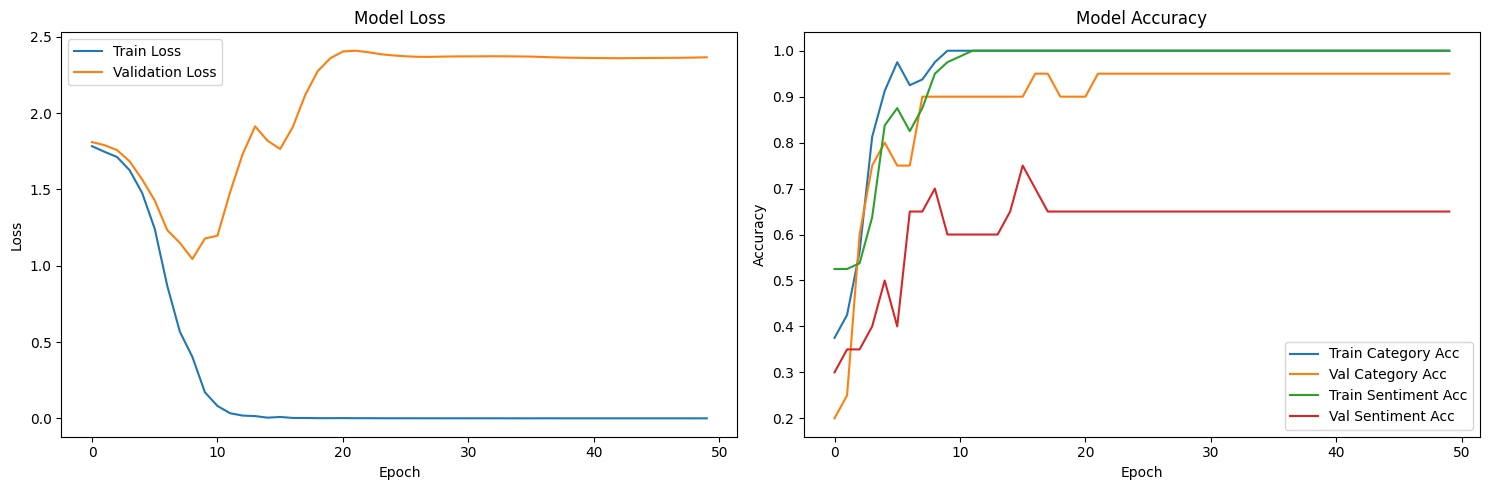

In [50]:
# Train with visualization
print("Starting training...")
history = train_and_visualize(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    learning_rate=0.001
)

### Overfitting

- Training accuracy reaches 100% for both tasks
- High validation loss (2.36) compared to training loss (0.0002)
- Large gap between training and validation metrics

### Performance Disparity

- **Category Classification:** Good (95% validation accuracy)
- **Sentiment Classification:** Moderate (65% validation accuracy)

In [62]:
# Updated BiLSTM model with stronger regularization
class BiLSTMClassifierV2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_categories, n_sentiments, n_layers=2, dropout=0.5):
        super(BiLSTMClassifierV2, self).__init__()

        # Word embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.3)

        # Separate BiLSTMs for each task
        self.category_lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=n_layers,
            bidirectional=True, dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        self.sentiment_lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=n_layers,
            bidirectional=True, dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Task-specific attention
        self.category_attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1),
            nn.Softmax(dim=1)
        )

        self.sentiment_attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1),
            nn.Softmax(dim=1)
        )

        # Category classifier
        self.category_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_categories)
        )

        # Sentiment classifier with extra layers
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, n_sentiments)
        )

    def apply_attention(self, lstm_output, attention_layer):
        attention_weights = attention_layer(lstm_output)
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

    def forward(self, text):
        # Embedding
        embedded = self.embedding(text)
        embedded = self.embedding_dropout(embedded)

        # Task-specific BiLSTM processing
        category_lstm_out, _ = self.category_lstm(embedded)
        sentiment_lstm_out, _ = self.sentiment_lstm(embedded)

        # Apply attention
        category_context = self.apply_attention(category_lstm_out, self.category_attention)
        sentiment_context = self.apply_attention(sentiment_lstm_out, self.sentiment_attention)

        # Classification
        category_output = self.category_classifier(category_context)
        sentiment_output = self.sentiment_classifier(sentiment_context)

        return category_output, sentiment_output

In [63]:
# Updated training function with task weighting
def train_model_v2(model, train_loader, val_loader, epochs=20, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Separate loss functions for each task
    category_criterion = nn.CrossEntropyLoss()
    sentiment_criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.48, 0.52]).to(device))  # Weighted loss for sentiment

    # Optimizer with different parameter groups
    optimizer = optim.AdamW([
        {'params': model.embedding.parameters(), 'lr': learning_rate * 0.1},
        {'params': model.category_lstm.parameters()},
        {'params': model.sentiment_lstm.parameters()},
        {'params': model.category_classifier.parameters()},
        {'params': model.sentiment_classifier.parameters(), 'lr': learning_rate * 2.0}
    ], lr=learning_rate, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    history = {'train_loss': [], 'val_loss': [],
               'train_cat_acc': [], 'val_cat_acc': [],
               'train_sent_acc': [], 'val_sent_acc': []}

    for epoch in range(epochs):
          model.train()
          total_loss = 0
          cat_correct = 0
          sent_correct = 0
          total = 0

          for texts, categories, sentiments in train_loader:
              texts = texts.to(device)
              categories = categories.squeeze().to(device)
              sentiments = sentiments.squeeze().to(device)

              # Forward pass
              cat_out, sent_out = model(texts)

              # Calculate loss
              cat_loss = category_criterion(cat_out, categories)
              sent_loss = sentiment_criterion(sent_out, sentiments)
              loss = cat_loss + sent_loss

              # Backward pass
              optimizer.zero_grad()
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              optimizer.step()

              # Calculate accuracy
              cat_pred = torch.argmax(cat_out, dim=1)
              sent_pred = torch.argmax(sent_out, dim=1)

              cat_correct += (cat_pred == categories).sum().item()
              sent_correct += (sent_pred == sentiments).sum().item()
              total += categories.size(0)

              total_loss += loss.item()

          # Calculate training metrics
          train_loss = total_loss / len(train_loader)
          train_cat_acc = cat_correct / total
          train_sent_acc = sent_correct / total

          # Validation
          val_loss, val_cat_acc, val_sent_acc = evaluate_model(model, val_loader, criterion, device)

          # Store history
          history['train_loss'].append(train_loss)
          history['val_loss'].append(val_loss)
          history['train_cat_acc'].append(train_cat_acc)
          history['val_cat_acc'].append(val_cat_acc)
          history['train_sent_acc'].append(train_sent_acc)
          history['val_sent_acc'].append(val_sent_acc)

          print(f'Epoch {epoch+1}/{epochs}:')
          print(f'Train Loss: {train_loss:.4f}, Cat Acc: {train_cat_acc:.4f}, Sent Acc: {train_sent_acc:.4f}')
          print(f'Val Loss: {val_loss:.4f}, Cat Acc: {val_cat_acc:.4f}, Sent Acc: {val_sent_acc:.4f}')
          print('-' * 60)

          return history


In [ ]:
# Training with visualization
def train_and_visualize(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    history = train_model_v2(model, train_loader, test_loader, epochs, learning_rate)

    # Plotting training history
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(history['train_cat_acc'], label='Train Category Acc')
    plt.plot(history['val_cat_acc'], label='Val Category Acc')
    plt.plot(history['train_sent_acc'], label='Train Sentiment Acc')
    plt.plot(history['val_sent_acc'], label='Val Sentiment Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return history

In [64]:
# Updated training parameters
EPOCHS = 30
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.01
BATCH_SIZE = 16

# Initialize new model
model_v2 = BiLSTMClassifierV2(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    n_categories=N_CATEGORIES,
    n_sentiments=N_SENTIMENTS,
    dropout=0.5
)

# Updated optimizer with weight decay
optimizer = optim.AdamW(model_v2.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)

# Create dataloaders with smaller batch size
train_loader, test_loader = create_dataloaders(
    X_train, X_test, y_cat_train, y_cat_test, y_sent_train, y_sent_test,
    preprocessor, BATCH_SIZE
)

Starting training...
Using device: cpu
Epoch 1/30:
Train Loss: 1.9855, Cat Acc: 0.2500, Sent Acc: 0.5000
Val Loss: 1.7662, Cat Acc: 0.2000, Sent Acc: 0.7000
------------------------------------------------------------
Epoch 2/30:
Train Loss: 1.7925, Cat Acc: 0.4500, Sent Acc: 0.4000
Val Loss: 1.8021, Cat Acc: 0.4000, Sent Acc: 0.2500
------------------------------------------------------------
Epoch 3/30:
Train Loss: 1.7549, Cat Acc: 0.4500, Sent Acc: 0.5375
Val Loss: 1.6581, Cat Acc: 0.6000, Sent Acc: 0.7500
------------------------------------------------------------
Epoch 4/30:
Train Loss: 1.5034, Cat Acc: 0.6875, Sent Acc: 0.6625
Val Loss: 1.6341, Cat Acc: 0.8000, Sent Acc: 0.7500
------------------------------------------------------------
Epoch 5/30:
Train Loss: 1.3881, Cat Acc: 0.7750, Sent Acc: 0.6625
Val Loss: 1.6070, Cat Acc: 0.7000, Sent Acc: 0.6500
------------------------------------------------------------
Epoch 6/30:
Train Loss: 1.2411, Cat Acc: 0.8125, Sent Acc: 0.5750


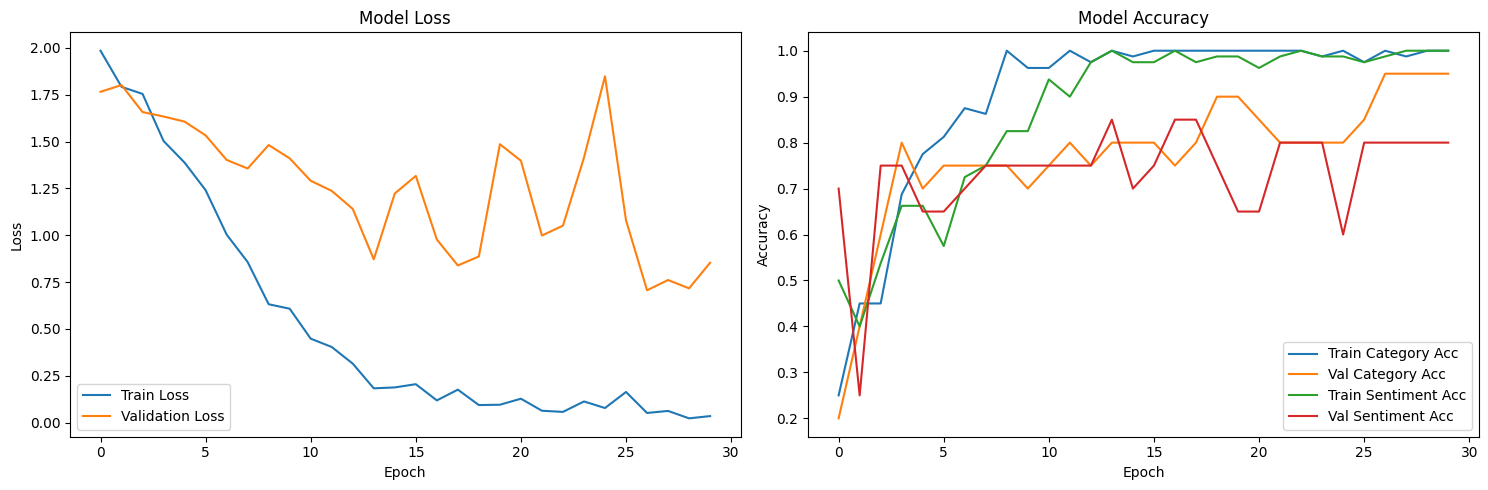

In [65]:
# Train with visualization
print("Starting training...")
history = train_and_visualize(
    model_v2,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE
)

## Key Observations

### Sentiment Classification

- Improved to ~80% validation accuracy (up from 65%)
- More stable performance across epochs

### Category Classification

- Maintained high accuracy (~95%)
- More consistent performance

### General Improvements

- Better generalization (smaller gap between train/val)
- More stable validation loss
- Earlier convergence


#  4: Model Analysis and Visualization

In [68]:
# import confusion metrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

In [69]:
# Model evaluation and visualization
def evaluate_final_model(model, test_loader, preprocessor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_cat_preds = []
    all_sent_preds = []
    all_cat_true = []
    all_sent_true = []
    examples = []

    with torch.no_grad():
        for texts, categories, sentiments in test_loader:
            texts = texts.to(device)
            cat_out, sent_out = model(texts)

            # Get predictions
            cat_preds = torch.argmax(cat_out, dim=1).cpu().numpy()
            sent_preds = torch.argmax(sent_out, dim=1).cpu().numpy()

            all_cat_preds.extend(cat_preds)
            all_sent_preds.extend(sent_preds)
            all_cat_true.extend(categories.numpy())
            all_sent_true.extend(sentiments.numpy())

            # Store some examples for analysis
            for i in range(len(texts)):
                examples.append({
                    'text': ' '.join([preprocessor.idx2word[idx.item()] for idx in texts[i] if idx.item() != 0]),
                    'true_category': preprocessor.category_encoder.inverse_transform([categories[i].item()])[0],
                    'pred_category': preprocessor.category_encoder.inverse_transform([cat_preds[i]])[0],
                    'true_sentiment': preprocessor.sentiment_encoder.inverse_transform([sentiments[i].item()])[0],
                    'pred_sentiment': preprocessor.sentiment_encoder.inverse_transform([sent_preds[i]])[0]
                })

    # Create confusion matrices
    plt.figure(figsize=(15, 5))

    # Category confusion matrix
    plt.subplot(1, 2, 1)
    cat_cm = confusion_matrix(all_cat_true, all_cat_preds)
    sns.heatmap(cat_cm,
                annot=True,
                fmt='d',
                xticklabels=preprocessor.category_encoder.classes_,
                yticklabels=preprocessor.category_encoder.classes_)
    plt.title('Category Classification Confusion Matrix')

    # Sentiment confusion matrix
    plt.subplot(1, 2, 2)
    sent_cm = confusion_matrix(all_sent_true, all_sent_preds)
    sns.heatmap(sent_cm,
                annot=True,
                fmt='d',
                xticklabels=preprocessor.sentiment_encoder.classes_,
                yticklabels=preprocessor.sentiment_encoder.classes_)
    plt.title('Sentiment Classification Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Print classification reports
    print("Category Classification Report:")
    print(classification_report(all_cat_true, all_cat_preds,
                              target_names=preprocessor.category_encoder.classes_))

    print("\nSentiment Classification Report:")
    print(classification_report(all_sent_true, all_sent_preds,
                              target_names=preprocessor.sentiment_encoder.classes_))

    # Show some example predictions
    print("\nExample Predictions:")
    for i, example in enumerate(examples[:5]):
        print(f"\nExample {i+1}:")
        print(f"Text: {example['text']}")
        print(f"Category: {example['true_category']} -> {example['pred_category']}")
        print(f"Sentiment: {example['true_sentiment']} -> {example['pred_sentiment']}")

    return examples

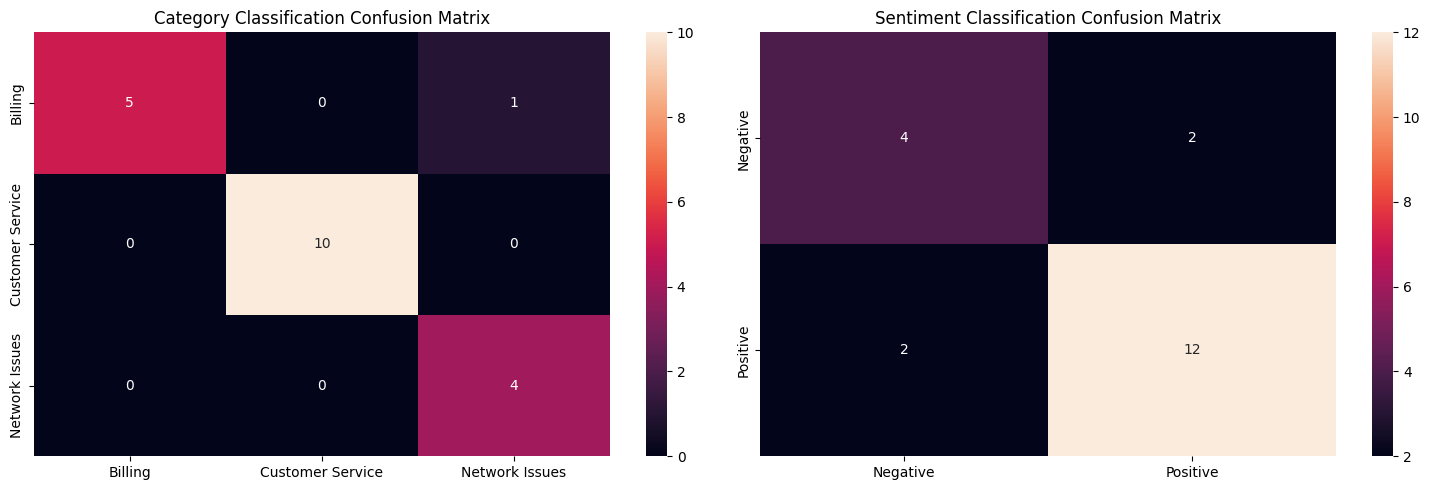

Category Classification Report:
                  precision    recall  f1-score   support

         Billing       1.00      0.83      0.91         6
Customer Service       1.00      1.00      1.00        10
  Network Issues       0.80      1.00      0.89         4

        accuracy                           0.95        20
       macro avg       0.93      0.94      0.93        20
    weighted avg       0.96      0.95      0.95        20


Sentiment Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.67      0.67         6
    Positive       0.86      0.86      0.86        14

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20


Example Predictions:

Example 1:
Text: had difficult time getting assistance from customer service .
Category: Customer Service -> Customer Service
Sentiment: Negative -> Negative

Example 2:
Text:

In [70]:
examples = evaluate_final_model(model_v2, test_loader, preprocessor)


In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
def predict_single_text(model, text, preprocessor):
    # Prepare the text
    tokens = preprocessor.clean_text(text)
    encoded = preprocessor.encode_text(text)
    input_tensor = torch.LongTensor([encoded]).to(device)

    model.eval()
    with torch.no_grad():
        cat_out, sent_out = model(input_tensor)

        # Get predictions
        cat_pred = preprocessor.category_encoder.inverse_transform(
            [torch.argmax(cat_out, dim=1).cpu().numpy()[0]])[0]
        sent_pred = preprocessor.sentiment_encoder.inverse_transform(
            [torch.argmax(sent_out, dim=1).cpu().numpy()[0]])[0]

        # Get probabilities
        cat_probs = torch.softmax(cat_out, dim=1).cpu().numpy()[0]
        sent_probs = torch.softmax(sent_out, dim=1).cpu().numpy()[0]

    return {
        'category': cat_pred,
        'category_confidence': float(max(cat_probs)),
        'sentiment': sent_pred,
        'sentiment_confidence': float(max(sent_probs)),
        'tokens': tokens
    }

In [78]:
text = "The network connection has been unstable lately, causing frustration."
prediction = predict_single_text(model_v2, text, preprocessor)
print("\nNew Text Prediction:")
print(f"Text: {text}")
print(f"Predicted Category: {prediction['category']} (Confidence: {prediction['category_confidence']:.2f})")
print(f"Predicted Sentiment: {prediction['sentiment']} (Confidence: {prediction['sentiment_confidence']:.2f})")
print(f"Tokens analyzed: {prediction['tokens']}")


New Text Prediction:
Text: The network connection has been unstable lately, causing frustration.
Predicted Category: Network Issues (Confidence: 1.00)
Predicted Sentiment: Negative (Confidence: 1.00)
Tokens analyzed: ['network', 'connection', 'has', 'been', 'unstable', 'lately', ',', 'causing', 'frustration', '.']
